# Validation of the PyPSA-Africa Installed capacity

This notebooks investigates the data quality of the African electric consumption
data by comparing PyPSA, official Nigerian and [IRENA statistics](https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle1.px/).

To reproduce the findings obtained in this notebook,
please run the full snakemake workflow for the Africa.
To do so, please set ``countries = ["Africa"]`` in the ``config.yaml`` file.

Note. An unoptimized prepared network is sufficient for this notebook. 

## Preparation

### Import packages

In [128]:
# import packages

import logging
import os

import pypsa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

### Set main directory to root folder

In [129]:
# set current folders
import sys

sys.path.append("../../")  # adds path to $ .../pypsa-africa
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-africa")  # moves path to root

This is the repository path:  /data/davidef/gitdf/pypsa-africa
Had to go 0 folder(s) up.


## 1. Load data 

#### IRENA data
Retrieved from [IRENA statistics](https://pxweb.irena.org/pxweb/en/IRENASTAT/IRENASTAT__Power%20Capacity%20and%20Generation/ELECCAP_2022_cycle1.px/).\
Please, download the statistics for 2020 for all the world and specify the url specified above.

In [130]:
from scripts._helpers import country_name_2_two_digits  # _helpers are from pypsa

year_select = 2020

IRENA_path = "ELECCAP_20220716-103856.csv"
df_irena = pd.read_csv(IRENA_path, skiprows=2, encoding="latin-1")
df_irena = df_irena[df_irena.loc[:, "Year"] == year_select]
df_irena = df_irena.iloc[:, [0, 2, 4]]
# df = df[df["iso_code"].notna()]  # removes antartica
df_irena["alpha2"] = df_irena.loc[:, "Country/area"].apply(
    lambda x: country_name_2_two_digits(x)
)
# electricity_demand_owid = df
# electricity_demand_owid.tail(2)

#### PyPSA generator data

Loads the PyPSA generators data

##### Load data from the network and create normalized dataframe

In [131]:
solved_network_path = os.getcwd() + "/networks/elec_s_55_ec.nc"
pypsa_network = pypsa.Network(solved_network_path)

# statistics of non-storage units
installed_capacity_nostorages = pypsa_network.generators.copy()
installed_capacity_nostorages.loc[:, "alpha2"] = (
    installed_capacity_nostorages.index.to_series().apply(lambda x: x[0:2]).values
)
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"].isin(["ror"]), "carrier"
] = "hydro"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"] == "onwind", "carrier"
] = "onshore wind"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"].isin(["offwind-ac", "off-shore-dc"]),
    "carrier",
] = "offshore wind"
installed_capacity_nostorages.loc[
    installed_capacity_nostorages["carrier"].isin(["CCGT", "OCGT"]), "carrier"
] = "gas"
installed_capacity_nostorages_select = installed_capacity_nostorages.loc[
    :, ["alpha2", "carrier", "p_nom"]
]

# statistics of storage units
installed_capacity_storages = pypsa_network.storage_units.copy()
installed_capacity_storages.loc[:, "alpha2"] = (
    installed_capacity_storages.index.to_series().apply(lambda x: x[0:2]).values
)
installed_capacity_storages.loc[
    installed_capacity_storages["carrier"] == "PHS", "carrier"
] = "hydro"
installed_capacity_storages_select = installed_capacity_storages.loc[
    :, ["alpha2", "carrier", "p_nom"]
]


installed_capacity_raw = pd.concat(
    [installed_capacity_storages_select, installed_capacity_nostorages_select]
)
installed_capacity = installed_capacity_raw.groupby(["alpha2", "carrier"])[
    "p_nom"
].sum()
installed_capacity.groupby("carrier").sum()

INFO:pypsa.io:Imported network elec_s_55_ec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


carrier
coal            40525.363358
gas             35202.323744
hydro           30090.654591
oil             49642.170076
onshore wind     6376.302032
solar            9150.483426
Name: p_nom, dtype: float64

##### Load PyPSA powerplant data to crosscheck data from the network

In [132]:
powerplants_data = os.getcwd() + "/resources/powerplants.csv"
available_generators = pd.read_csv(powerplants_data)
installed_capacity_resources = available_generators.groupby(["Country", "Fueltype"])[
    "Capacity"
].sum()
installed_capacity_resources.groupby(["Fueltype"]).sum()

Fueltype
CCGT     1472.098949
Hydro    1905.414013
OCGT     6021.930479
Oil      2187.625059
Name: Capacity, dtype: float64

# 2. Validate

#### Steps:
- Specify year of interest of the IRENA dataset and the countries of interest
- Harmonize IRENA dataset to the PyPSA standard
- Align dataframe naming and temporal resolution
- Merge dataframe


##### Specify year of the analysis and the countries of interest

In [133]:
year_owid = 2020  # option
country_list = installed_capacity_nostorages.alpha2.unique()
country_list

array(['AO', 'BI', 'BJ', 'BW', 'CD', 'CF', 'CG', 'CI', 'CM', 'DZ', 'EG',
       'EH', 'ER', 'ET', 'GA', 'GH', 'GM', 'GN', 'GQ', 'GW', 'KE', 'LR',
       'LS', 'LY', 'MA', 'MG', 'ML', 'MR', 'MW', 'MZ', 'NA', 'NE', 'NG',
       'RW', 'SD', 'SL', 'SN', 'SO', 'SS', 'SZ', 'TD', 'TG', 'TN', 'TZ',
       'UG', 'ZA', 'ZM', 'ZW'], dtype=object)

##### Process IRENA data to match PyPSA standard

In [134]:
# copy IRENA dataset
df = df_irena.copy()

# Process technologies
df.loc[
    df["Technology"].isin(["Solar photovoltaic", "Solar thermal energy"]), "Technology"
] = "solar"
df.loc[
    df["Technology"].isin(["Onshore wind energy", "Offshore wind energy"]), "Technology"
] = "wind"
df.loc[
    df["Technology"].isin(
        ["Renewable hydropower", "Mixed Hydro Plants", "Pumped storage"]
    ),
    "Technology",
] = "hydro"
df.loc[
    df["Technology"].isin(["Other non-renewable energy", "Marine energy"]), "Technology"
] = "other"
df.loc[
    df["Technology"].isin(["Liquid biofuels", "Biogas", "Solid biofuels"]), "Technology"
] = "bioenergy"
df.loc[df["Technology"].isin(["Geothermal energy"]), "Technology"] = "geothermal"
df.loc[df["Technology"].isin(["Natural gas"]), "Technology"] = "gas"
df.loc[df["Technology"].isin(["Renewable municipal waste"]), "Technology"] = "waste"
df.loc[df["Technology"].isin(["Coal and peat"]), "Technology"] = "coal"
df.loc[df["Technology"].isin(["Oil", "Fossil fuels n.e.s."]), "Technology"] = "oil"


df = df[df.alpha2.isin(country_list)]
df["p_nom"] = pd.to_numeric(df["Installed electricity capacity (MW)"], errors="coerce")
installed_capacity_irena = (
    df.rename(columns={"Technology": "carrier"})
    .groupby(["alpha2", "carrier"])["p_nom"]
    .sum()
)
installed_capacity_irena.groupby("carrier").sum()

carrier
Nuclear            1940.000
bioenergy          1462.517
coal              47471.600
gas              100760.933
geothermal          870.300
hydro             33376.493
offshore wind         0.000
oil               26367.624
onshore wind       6421.323
other               100.000
solar             10364.006
waste                25.000
Name: p_nom, dtype: float64

##### Merge datasets by carrier

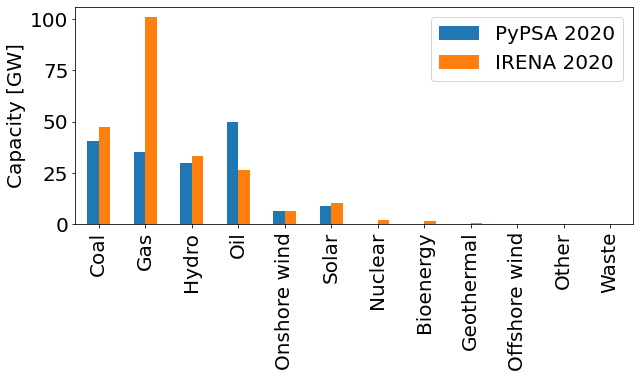

In [135]:
world_ic = installed_capacity_irena.groupby("carrier").sum() / 1000
world_ic.index = world_ic.index.str.capitalize()

world_pypsa = installed_capacity.groupby("carrier").sum() / 1000
world_pypsa.index = world_pypsa.index.str.capitalize()

world_compare = pd.concat(
    [world_pypsa.rename("PyPSA 2020"), world_ic.rename("IRENA 2020")], axis=1
)
ax = world_compare.plot.bar(
    ylabel="Capacity [GW]", xlabel="Technology", figsize=(10, 4)
)
ax.set(xlabel=None);

<AxesSubplot:xlabel='Technology', ylabel='Capacity [GW]'>

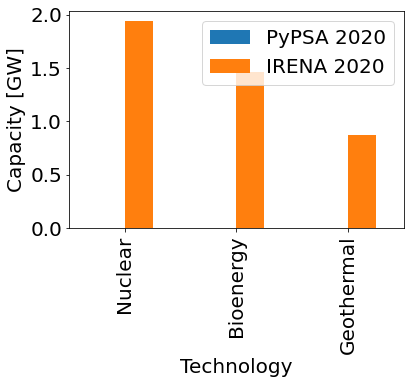

In [136]:
list_carriers = [
    "coal",
    "gas",
    "hydro",
    "oil",
    "onshore wind",
    "solar",
    "Bioenergy",
    "Geothermal",
    "Nuclear",
]

world_compare[world_compare.index.isin(list_carriers)].plot.bar(
    ylabel="Capacity [GW]", xlabel="Technology"
)

##### Merge dataframes by country

[Text(0.5, 0, '')]

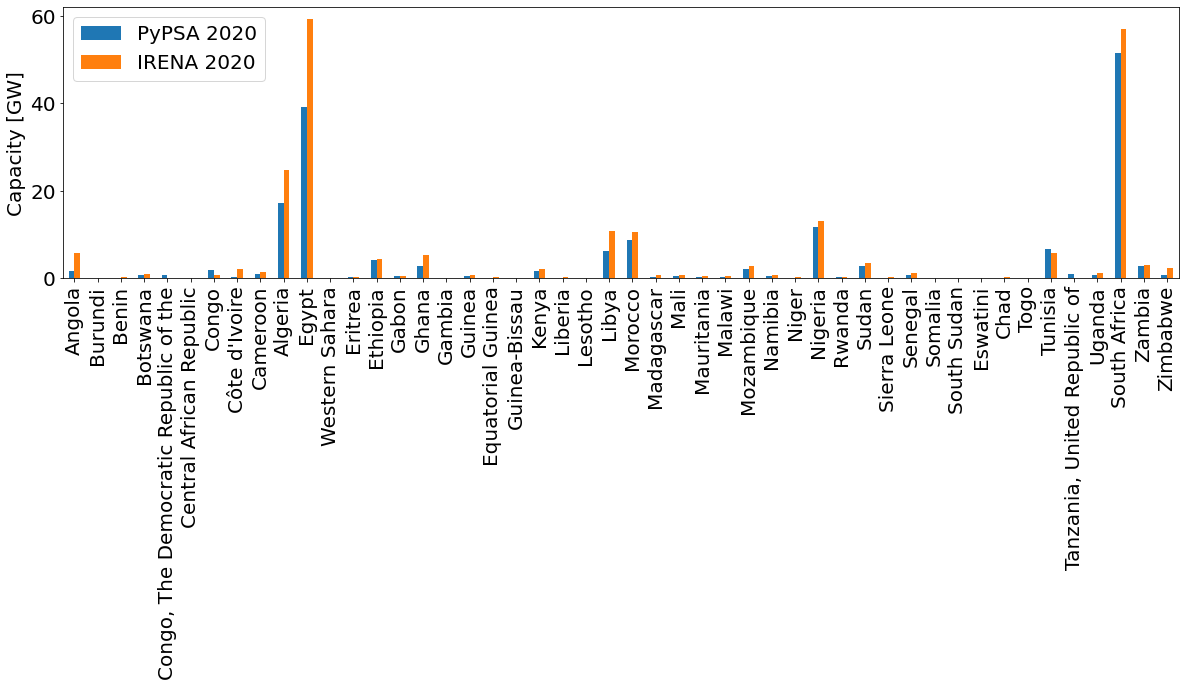

In [137]:
from scripts._helpers import two_digits_2_name_country

country_ic = (
    installed_capacity_irena[
        installed_capacity_irena.index.get_level_values(1).isin(list_carriers)
    ]
    .groupby("alpha2")
    .sum()
    / 1000
)
country_pypsa = (
    installed_capacity[installed_capacity.index.get_level_values(1).isin(list_carriers)]
    .groupby("alpha2")
    .sum()
    / 1000
)

country_compare = pd.concat(
    [country_pypsa.rename("PyPSA 2020"), country_ic.rename("IRENA 2020")], axis=1
)
country_compare.index = country_compare.index.map(two_digits_2_name_country)
plt.rcParams.update({"font.size": 20})
ax = country_compare.plot.bar(
    figsize=(20, 5), ylabel="Capacity [GW]", xlabel="Country", fontsize=20
)
ax.set(xlabel=None)

In [138]:
# Installed capacities of a technology by country
# df[df.Technology=="gas"].groupby("alpha2")["p_nom"].sum()
# installed_capacity_nostorages_select[installed_capacity_nostorages_select.carrier == "gas"].groupby("alpha2")["p_nom"].sum()